# Hydraulic head change training 

## Preliminaries

In [1]:
# Imports
import importlib
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split

#ML imports
import torch
import torch.nn as nn
import torch.optim as optim


## Custom modules
import utils.DynamicEmulator as DE
import utils.head_change_utils as utils
from models.mlp_q_interchange import QInterchangeNN 
from models.mlp_q_interchange import count_parameters

# Open the file and load the file
yaml_path = 'config_file.yaml'
yaml_data = utils.load_yaml(yaml_path)

# Directories
simulations_path = yaml_data['simulations_path']
inp_path =  yaml_data['inp_path']
rain_path = simulations_path + '\\block' + '\\block.dat'
heads_path = simulations_path + '\\block' + '\\rainblock_head_TuindorpRP.pk'

## Read data from rainfall and hydraulic head

In [2]:
#Rainfall
rainfall_raw_data = utils.get_rain_in_pandas(rain_path)

#Hydraulic head
head_raw_data = utils.get_info_from_pickle(heads_path)
head_raw_data.columns = head_raw_data.columns.str.replace("_Hydraulic_head", "")
head_raw_data.columns = head_raw_data.columns.str.replace("node_", "")

In [3]:
#Periods without rain
# dry_periods_index = rainfall_raw_data[rainfall_raw_data['value']==0].index
dry_periods_index = [[12, 13, 14, 15, 16, 17],          #First dry period
                     [24, 25, 26, 27, 28, 29, 30, 31,], #Second dry period
                     [38, 39, 40, 41, 42, 43, 44, 45],  #Third dry period
                     [52, 53, 54, 55, 56, 57],          #Fourth dry period
                     [64, 65, 66, 67, 68, 69],          #Fifth dry period
                     [76, 77, 78, 79, 80, 81, 82, 83, 84] #Last dry period
                    ]
val_index = 3
training_dry_periods_index = dry_periods_index[:val_index]+dry_periods_index[val_index+1:]
val_dry_period_indexes =  [dry_periods_index[val_index]]

#### Couples of training events

In [4]:
h0_values = []
h1_values = []

for dry_period in training_dry_periods_index:
    heads_no_rain = head_raw_data.iloc[list(dry_period), :]
    initial_heads, next_heads = utils.get_h0_h1_couples(heads_no_rain)
    
    h0_values.extend(initial_heads)
    h1_values.extend(next_heads)


#### Rolled-out validation event

In [5]:
rolled_out_target_hydraulic_heads = []

for dry_period in val_dry_period_indexes:
    heads_no_rain = head_raw_data.iloc[list(dry_period), :]
    heads = utils.get_rolled_out_target_hydraulic_heads(heads_no_rain)
    
    rolled_out_target_hydraulic_heads.append(heads)

## Separate samples in training/validation/testing

In [6]:
# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(h0_values, h1_values,
    test_size=0.2, shuffle = True, random_state = 8)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

## Data preprocessing

### Normalization

In [7]:
#It considers all heads with the same scaling
max, min = utils.get_max_and_min(X_train + y_train) 

normalized_x = utils.normalize_sample_values(X_train, max, min)
normalized_y = utils.normalize_sample_values(y_train, max, min)

### Visualization

In [8]:
# For a single node
node_name = 'j_90492'
single_node_x = []
single_node_y = []
length_database = len(normalized_x) #same as y_train
for i in range(length_database):
    single_node_x.append(normalized_x[i][node_name])
    single_node_y.append(normalized_y[i][node_name])


In [9]:
fig = utils.plot_head_changes(node_name, single_node_x, single_node_y)
fig.show()

## Model

### Artificial Neural Network definition

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
q_transfer_ANN = QInterchangeNN().to(device)
print(q_transfer_ANN)

QInterchangeNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
  )
)


### Model definition

In [12]:
wn = DE.DynamicEmulator(inp_path, X_train[0], q_transfer_ANN)

There are no [STORAGE]
 in the file
The file does not have pumps. A handled exception occured because of '[PUMPS]\n'
The file does not have orifices. A handled exception occured because of '[ORIFICES]\n'
The file does not have weirs. A handled exception occured because of '[WEIRS]\n'


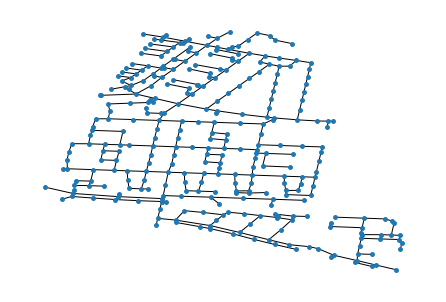

In [13]:
#Draw graph
wn.draw_nx_layout()

### Dynamic emulator

In [14]:
wn.set_h(X_train[0])
columns = ['Time' , 'Node', 'Depth', 'x_coord' , 'y_coord']
df = pd.DataFrame(wn.get_depths_to_rows(0), columns = columns)

for time in range(5):
    wn.update_h() 
    new_h_rows = pd.DataFrame(wn.get_depths_to_rows(time+1), columns = columns)
    df = pd.concat([df,new_h_rows])

<AxesSubplot:>

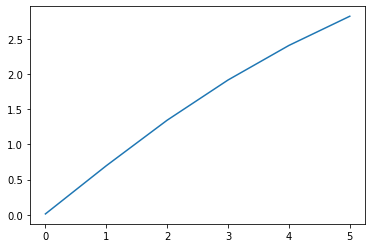

In [15]:
depth_one_node = df[df['Node']=='j_90376']['Depth'] #.plot() j_90550
depth_one_node=depth_one_node.reset_index()
depth_one_node['Depth'].plot()

In [16]:
net = px.scatter(
                df, 
                x="x_coord", 
                y="y_coord", 
                size="Depth", 
                animation_frame="Time", 
                size_max=20, 
                hover_name="Node",
                width=500, 
                height=800
                )
net.show()

In [17]:
# net.write_html('Depth_dynamic_viz.html')

In [18]:
rolled_out_heads = rolled_out_target_hydraulic_heads[0]#[val_index]

val_df = pd.DataFrame(wn.get_custom_depths_to_rows(0,rolled_out_heads[0]), columns = columns)

for time in range(len(rolled_out_heads)-1):
    new_h_rows = pd.DataFrame(wn.get_custom_depths_to_rows(time+1,rolled_out_heads[time+1]), columns = columns)
    val_df = pd.concat([val_df,new_h_rows])


SWMM_net = px.scatter(
                val_df, 
                x="x_coord", 
                y="y_coord", 
                size="Depth", 
                animation_frame="Time", 
                size_max=20, 
                hover_name="Node",
                width=500, 
                height=800
                )
SWMM_net.show()

In [19]:
SWMM_net.write_html('SWMM_Depth_dynamic_viz.html')

### Model training

In [20]:
optimizer = optim.SGD(wn.q_transfer_ANN.parameters(), lr=0.0005, momentum=0.9)
losses=[]

for epoch in range(20):
    epoch_losses =[]
    for i in range(len(X_train)):
        wn.set_h(X_train[i])

        for time in range(1):
            wn.update_h() 

        pred = torch.cat(list(wn.get_h().values()))
        target = torch.reshape(torch.tensor(list(y_train[i].values())), (-1,1))

        loss = nn.MSELoss()(pred, target)
        epoch_losses.append(loss.detach())
        
        if loss.requires_grad:
            # Backpropagate and update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)      

    losses.append(np.array(epoch_losses).mean())

<AxesSubplot:>

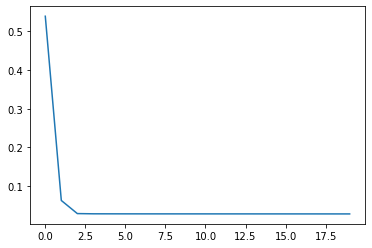

In [21]:
pd.Series(np.array(losses)).plot()

### Model validation

In [22]:
wn.set_h(X_train[0])
columns = ['Time' , 'Node', 'Depth', 'x_coord' , 'y_coord']
df = pd.DataFrame(wn.get_depths_to_rows(0), columns = columns)

for time in range(5):
    wn.update_h() 
    new_h_rows = pd.DataFrame(wn.get_depths_to_rows(time+1), columns = columns)
    df = pd.concat([df,new_h_rows])

<AxesSubplot:>

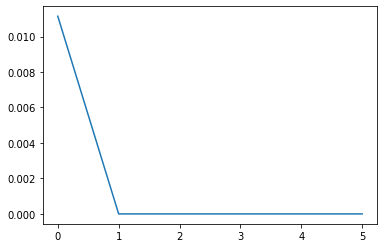

In [23]:
depth_one_node = df[df['Node']=='j_90376']['Depth'] #.plot() j_90550
depth_one_node=depth_one_node.reset_index()
depth_one_node['Depth'].plot()

In [24]:
net = px.scatter(
                df, 
                x="x_coord", 
                y="y_coord", 
                size="Depth", 
                animation_frame="Time", 
                size_max=20, 
                hover_name="Node",
                width=500, 
                height=800
                )
net.show()

In [25]:
net.write_html('test_Depth_dynamic_viz.html')

### Model testing

## Predictions visualization

## Export model

# Scratchpad